In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv("A:/Library/Downloads/archive/US_Accidents_March23.csv")

## 2. Cleaning Data

### Preparing the data for the model

In [3]:
df = data.copy()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   ID                     object 
 1   Source                 object 
 2   Severity               int64  
 3   Start_Time             object 
 4   End_Time               object 
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object 
 11  Street                 object 
 12  City                   object 
 13  County                 object 
 14  State                  object 
 15  Zipcode                object 
 16  Country                object 
 17  Timezone               object 
 18  Airport_Code           object 
 19  Weather_Timestamp      object 
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)       

In [5]:
# Checking for duplicate values
df.duplicated().sum()

0

In [6]:
# Checking for missing values
df.isnull().sum()

ID                             0
Source                         0
Severity                       0
Start_Time                     0
End_Time                       0
Start_Lat                      0
Start_Lng                      0
End_Lat                  3402762
End_Lng                  3402762
Distance(mi)                   0
Description                    5
Street                     10869
City                         253
County                         0
State                          0
Zipcode                     1915
Country                        0
Timezone                    7808
Airport_Code               22635
Weather_Timestamp         120228
Temperature(F)            163853
Wind_Chill(F)            1999019
Humidity(%)               174144
Pressure(in)              140679
Visibility(mi)            177098
Wind_Direction            175206
Wind_Speed(mph)           571233
Precipitation(in)        2203586
Weather_Condition         173459
Amenity                        0
Bump      

In [7]:
missing_percentage = df.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(
    ascending=False
)

<Axes: >

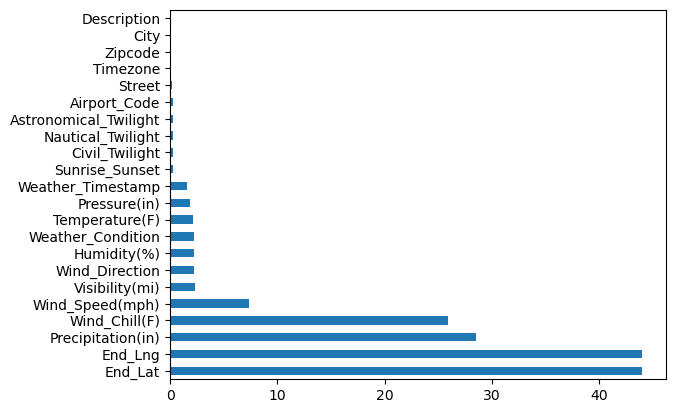

In [8]:
missing_percentage.plot(kind="barh")

Here we will drop the columns which has more than 20% of missing values.

In [9]:
df = df.drop(["End_Lat", "End_Lng", "Precipitation(in)", "Wind_Chill(F)"], axis=1)

In [10]:
df.columns

Index(['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County',
       'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code',
       'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')

In [11]:
num_cols = df.select_dtypes(include=["float64", "int64"]).columns
cat_cols = df.select_dtypes(include=["object"]).columns

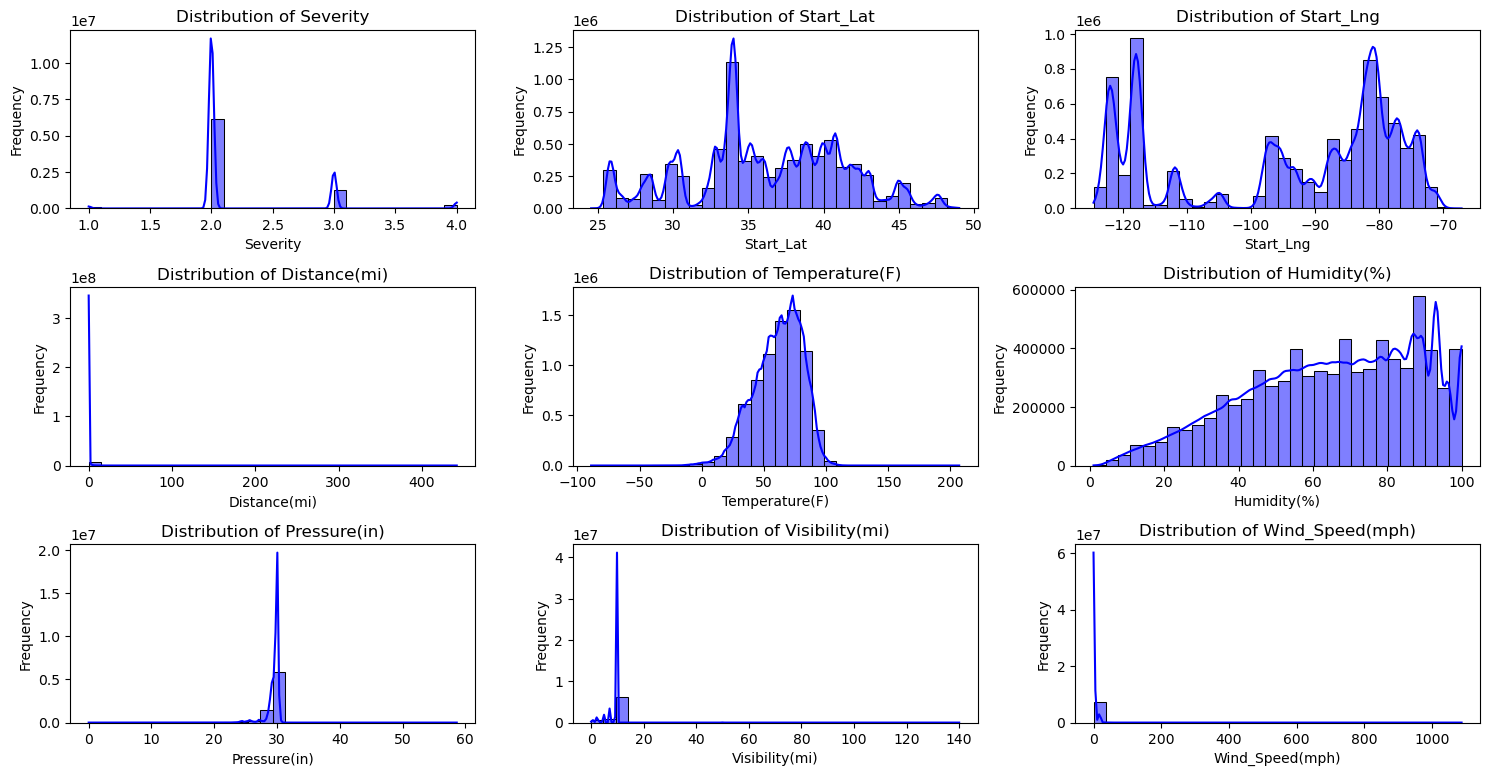

In [12]:
# Plot the distribution of each numerical column to see how to impute the missing values
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols, 1):
    plt.subplot(len(num_cols) // 3 + 1, 3, i)
    sns.histplot(df[col], kde=True, bins=30, color="blue")
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

Here we will use the mean for filling  Temperature(F) due to its symmetry and the median for other columns to mitigate the effects of outliers and skewed distributions

In [13]:
df["Temperature(F)"].fillna(df["Temperature(F)"].mean(), inplace=True)

C:\Users\ameyj\AppData\Local\Temp\ipykernel_4216\1578040165.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Temperature(F)"].fillna(df["Temperature(F)"].mean(), inplace=True)


In [14]:
med_fill = [i for i in num_cols if i not in ["Temperature(F)"]]
df[med_fill] = df[med_fill].fillna(df[med_fill].median())

In [15]:
# Mode for categorical columns
df[cat_cols] = df[cat_cols].fillna(df[cat_cols].mode().iloc[0])

In [16]:
df.isnull().sum()

ID                       0
Source                   0
Severity                 0
Start_Time               0
End_Time                 0
Start_Lat                0
Start_Lng                0
Distance(mi)             0
Description              0
Street                   0
City                     0
County                   0
State                    0
Zipcode                  0
Country                  0
Timezone                 0
Airport_Code             0
Weather_Timestamp        0
Temperature(F)           0
Humidity(%)              0
Pressure(in)             0
Visibility(mi)           0
Wind_Direction           0
Wind_Speed(mph)          0
Weather_Condition        0
Amenity                  0
Bump                     0
Crossing                 0
Give_Way                 0
Junction                 0
No_Exit                  0
Railway                  0
Roundabout               0
Station                  0
Stop                     0
Traffic_Calming          0
Traffic_Signal           0
T

## Feature Engineering

We will drop columns which are not useful for the model. We will also create new features from the existing ones.

In [17]:
# Dropping columns that are not needed
df = df.drop(
    [
        "ID",
        "Description",
        "County",
        "Zipcode",
        "Timezone",
        "Airport_Code",
        "Wind_Direction",
        "Civil_Twilight",
        "Nautical_Twilight",
        "Astronomical_Twilight",
    ],
    axis=1,
)

In [18]:
df.columns

Index(['Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Street', 'City', 'State', 'Country',
       'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset'],
      dtype='object')

In [19]:
df.head()

,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Street,City,State,...,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset
0,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,0.01,I-70 E,Dayton,OH,...,False,False,False,False,False,False,False,False,False,Night
1,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,0.01,Brice Rd,Reynoldsburg,OH,...,False,False,False,False,False,False,False,False,False,Night
2,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,0.01,State Route 32,Williamsburg,OH,...,False,False,False,False,False,False,False,True,False,Night
3,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,0.01,I-75 S,Dayton,OH,...,False,False,False,False,False,False,False,False,False,Night
4,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,0.01,Miamisburg Centerville Rd,Dayton,OH,...,False,False,False,False,False,False,False,True,False,Day


In [20]:
# check for unique values of each col
cat_cols = df.select_dtypes(include=["object"]).columns

for cat in cat_cols:
    print(cat, df[cat].nunique())

Source 3
Start_Time 6131796
End_Time 6705355
Street 336306
City 13678
State 49
Country 1
Weather_Timestamp 941331
Weather_Condition 144
Sunrise_Sunset 2


In [21]:
# drop country col because it has only one value
df = df.drop(columns=["Country"])

## Class Imbalance

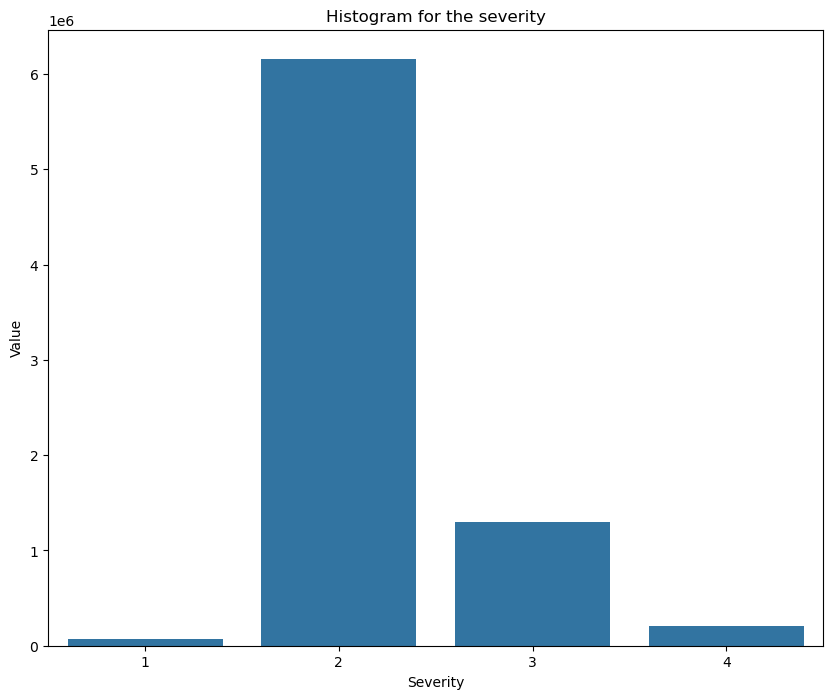

In [22]:
# check if the data is unbalenced
severity_counts = df["Severity"].value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(x=severity_counts.index, y=severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

As observed in the previous plot, the severity attribute is highly imbalanced, with very few accidents classified as severity 1, while severity 2 accidents are much more prevalent. To address this imbalance, we will undersample all categories so that each has the same number of records as the minority category, which in this case is severity 1.

## 3. Exploratory Data Analysis

### Feature Scaling
as from above graph we conclude that the data is not normally distributed so we will use MinMaxScaler for scaling the data. 

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

scalermax = MinMaxScaler()
scalerstd = StandardScaler()
med_fill = [col for col in med_fill if col != "Severity"]
df[med_fill] = scalermax.fit_transform(df[med_fill])
df["Temperature(F)"] = scalerstd.fit_transform(df[["Temperature(F)"]])

### EDA

In [24]:
# Analysis by Temperature
acci_temp = df["Temperature(F)"].value_counts()
acci_temp

Temperature(F)
 8.153050e-01    170991
 6.026636e-01    170898
 6.043632e-15    163853
 3.368619e-01    163767
 5.495033e-01    160498
                  ...  
-3.192985e+00         1
-4.420989e+00         1
 3.473322e+00         1
 5.121293e+00         1
 3.771020e+00         1
Name: count, Length: 861, dtype: int64

<Axes: xlabel='Temperature(F)', ylabel='Count'>

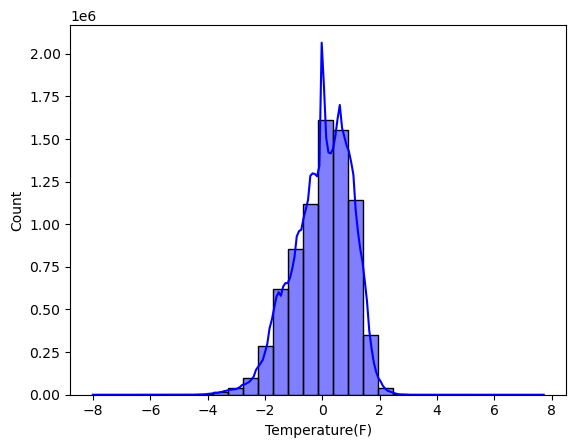

In [25]:
sns.histplot(df["Temperature(F)"], kde=True, bins=30, color="blue", edgecolor="black")

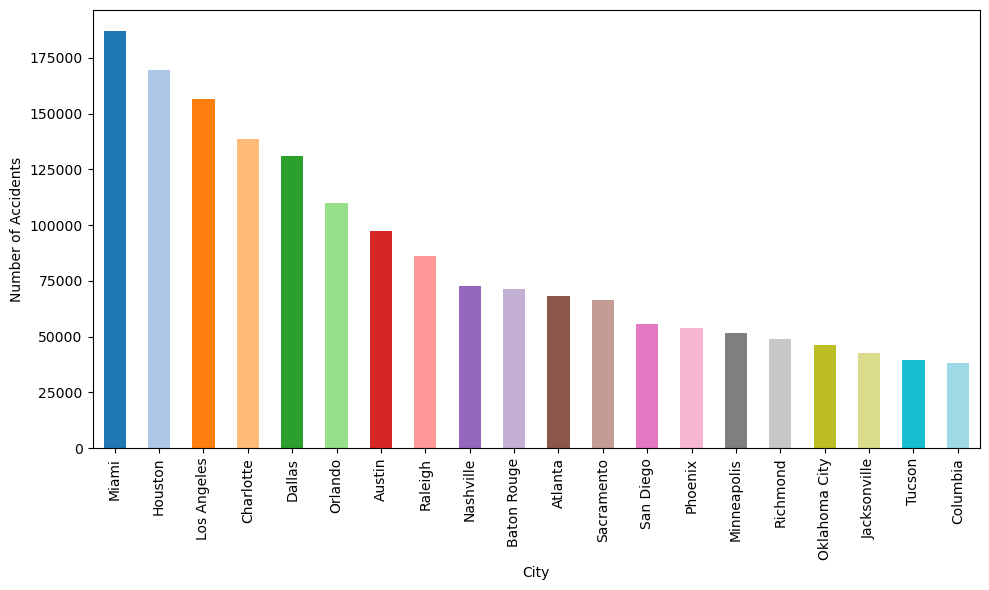

In [26]:
# Analysis by location:
# Get the top 20 cities with the most accidents
accidents_by_city = df["City"].value_counts()

top_20_cities = accidents_by_city.head(20)

# Create the bar plot
plt.figure(figsize=(10, 6))
color_range = range(50)
top_20_cities.plot(kind="bar", color=plt.get_cmap("tab20")(range(len(color_range))))

plt.xlabel("City")
plt.ylabel("Number of Accidents")

# Show the bar plot
plt.tight_layout()
plt.show()

<Axes: ylabel='Weather_Condition'>

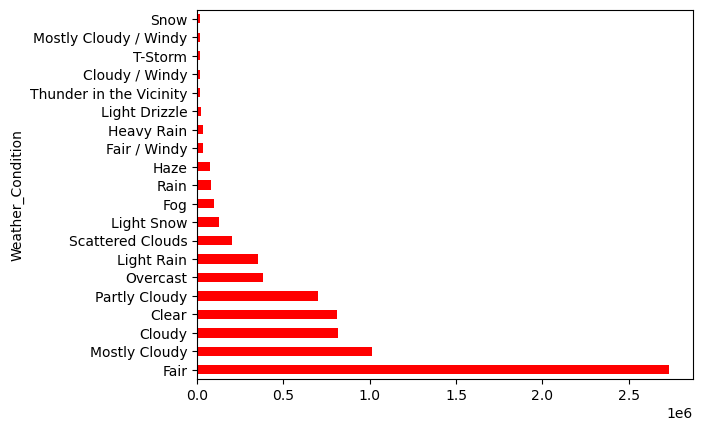

In [27]:
df.Weather_Condition.value_counts().sort_values(ascending=False)[:20].plot(
    kind="barh", color="red"
)

<Axes: xlabel='Start_Time', ylabel='Density'>

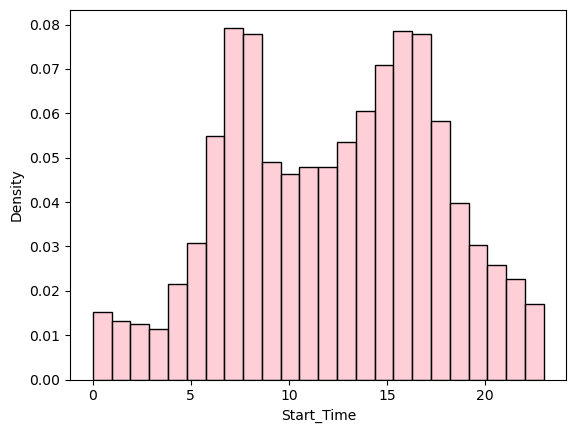

In [28]:
# Analaysis by Date
df.Start_Time = pd.to_datetime(df["Start_Time"], format="mixed", errors="coerce")
sns.histplot(df.Start_Time.dt.hour, bins=24, kde=False, stat="density", color="pink")

we see that most of the Accidents occured in between the 6am to 9am and other is 2pm to 6pm

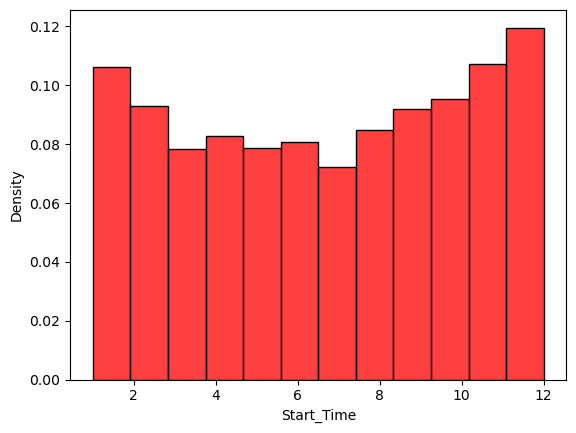

In [29]:
sns.histplot(df.Start_Time.dt.month, kde=False, bins=12, stat="density", color="red")
plt.show()

so in Winter and Rainy seasons there is more chances of occuring accidents chances

### Changing date and time to numerical values

In [30]:
df["Start_Time"] = pd.to_datetime(df["Start_Time"], errors="coerce", format="mixed")
df["End_Time"] = pd.to_datetime(df["End_Time"], errors="coerce", format="mixed")

In [31]:
df["Start_Year"] = df["Start_Time"].dt.year
df["Start_Month"] = df["Start_Time"].dt.month
df["Start_Day"] = df["Start_Time"].dt.day
df["Start_Hour"] = df["Start_Time"].dt.hour
df["Start_Weekday"] = df["Start_Time"].dt.weekday  # Monday=0, Sunday=6
df["Is_Weekend"] = df["Start_Weekday"].apply(lambda x: 1 if x >= 5 else 0)

In [32]:
df.columns

Index(['Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat',
       'Start_Lng', 'Distance(mi)', 'Street', 'City', 'State',
       'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Speed(mph)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Start_Year', 'Start_Month',
       'Start_Day', 'Start_Hour', 'Start_Weekday', 'Is_Weekend'],
      dtype='object')

In [33]:
df = df.drop(columns=["Start_Time", "End_Time"])

### Feature Encoding

In [34]:
# encoding 'Source'(3 cat) , 'Sunrise_Sunset'(2cat) with one hot encoding because they don't have a lot of categories
df = pd.get_dummies(df, drop_first=True, columns=["Source", "Sunrise_Sunset"])

In [35]:
df.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Street,City,State,Weather_Timestamp,Temperature(F),Humidity(%),...,Turning_Loop,Start_Year,Start_Month,Start_Day,Start_Hour,Start_Weekday,Is_Weekend,Source_Source2,Source_Source3,Sunrise_Sunset_Night
0,3,0.626257,0.705349,0.000023,I-70 E,Dayton,OH,2016-02-08 05:58:00,-1.316425,0.909091,...,False,2016,2,8,5,0,0,True,False,True
1,2,0.628830,0.726694,0.000023,Brice Rd,Reynoldsburg,OH,2016-02-08 05:51:00,-1.263264,1.000000,...,False,2016,2,8,6,0,0,True,False,True
2,2,0.593452,0.705803,0.000023,State Route 32,Williamsburg,OH,2016-02-08 06:56:00,-1.364269,1.000000,...,False,2016,2,8,6,0,0,True,False,True
3,3,0.621455,0.702796,0.000023,I-75 S,Dayton,OH,2016-02-08 07:38:00,-1.412113,0.959596,...,False,2016,2,8,7,0,0,True,False,True
4,2,0.616547,0.703095,0.000023,Miamisburg Centerville Rd,Dayton,OH,2016-02-08 07:53:00,-1.364269,0.888889,...,False,2016,2,8,7,0,0,True,False,False


In [36]:
# List of columns to be target encoded
columns_to_encode = ["Street", "Weather_Timestamp", "City", "Weather_Condition"]

# Apply target encoding for each column
for column in columns_to_encode:
    mean_values = df.groupby(column)["Severity"].mean()
    df[column] = df[column].map(mean_values)

In [37]:
df.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Street,City,State,Weather_Timestamp,Temperature(F),Humidity(%),...,Turning_Loop,Start_Year,Start_Month,Start_Day,Start_Hour,Start_Weekday,Is_Weekend,Source_Source2,Source_Source3,Sunrise_Sunset_Night
0,3,0.626257,0.705349,0.000023,2.501193,2.113992,OH,2.5,-1.316425,0.909091,...,False,2016,2,8,5,0,0,True,False,True
1,2,0.628830,0.726694,0.000023,2.352459,2.277311,OH,2.0,-1.263264,1.000000,...,False,2016,2,8,6,0,0,True,False,True
2,2,0.593452,0.705803,0.000023,2.234127,2.395349,OH,2.0,-1.364269,1.000000,...,False,2016,2,8,6,0,0,True,False,True
3,3,0.621455,0.702796,0.000023,2.524976,2.113992,OH,3.0,-1.412113,0.959596,...,False,2016,2,8,7,0,0,True,False,True
4,2,0.616547,0.703095,0.000023,2.198903,2.113992,OH,2.5,-1.364269,0.888889,...,False,2016,2,8,7,0,0,True,False,False


In [38]:
df.dtypes

Severity                  int64
Start_Lat               float64
Start_Lng               float64
Distance(mi)            float64
Street                  float64
City                    float64
State                    object
Weather_Timestamp       float64
Temperature(F)          float64
Humidity(%)             float64
Pressure(in)            float64
Visibility(mi)          float64
Wind_Speed(mph)         float64
Weather_Condition       float64
Amenity                    bool
Bump                       bool
Crossing                   bool
Give_Way                   bool
Junction                   bool
No_Exit                    bool
Railway                    bool
Roundabout                 bool
Station                    bool
Stop                       bool
Traffic_Calming            bool
Traffic_Signal             bool
Turning_Loop               bool
Start_Year                int32
Start_Month               int32
Start_Day                 int32
Start_Hour                int32
Start_We

In [39]:
df["State"].unique()

array(['OH', 'WV', 'CA', 'FL', 'GA', 'SC', 'NE', 'IA', 'IL', 'MO', 'WI',
       'IN', 'MI', 'NJ', 'NY', 'CT', 'MA', 'RI', 'NH', 'PA', 'KY', 'MD',
       'VA', 'DC', 'DE', 'TX', 'WA', 'OR', 'AL', 'NC', 'AZ', 'TN', 'LA',
       'MN', 'CO', 'OK', 'NV', 'UT', 'KS', 'NM', 'AR', 'MS', 'ME', 'VT',
       'WY', 'ID', 'ND', 'MT', 'SD'], dtype=object)

In [40]:
# encode State with binary encoding
from category_encoders import BinaryEncoder

state_encoder = BinaryEncoder()
state_encoded = state_encoder.fit_transform(df["State"])
df = pd.concat([df, state_encoded], axis=1)

# drop state
df = df.drop(columns=["State"])

In [41]:
df.dtypes

Severity                  int64
Start_Lat               float64
Start_Lng               float64
Distance(mi)            float64
Street                  float64
City                    float64
Weather_Timestamp       float64
Temperature(F)          float64
Humidity(%)             float64
Pressure(in)            float64
Visibility(mi)          float64
Wind_Speed(mph)         float64
Weather_Condition       float64
Amenity                    bool
Bump                       bool
Crossing                   bool
Give_Way                   bool
Junction                   bool
No_Exit                    bool
Railway                    bool
Roundabout                 bool
Station                    bool
Stop                       bool
Traffic_Calming            bool
Traffic_Signal             bool
Turning_Loop               bool
Start_Year                int32
Start_Month               int32
Start_Day                 int32
Start_Hour                int32
Start_Weekday             int32
Is_Weeke

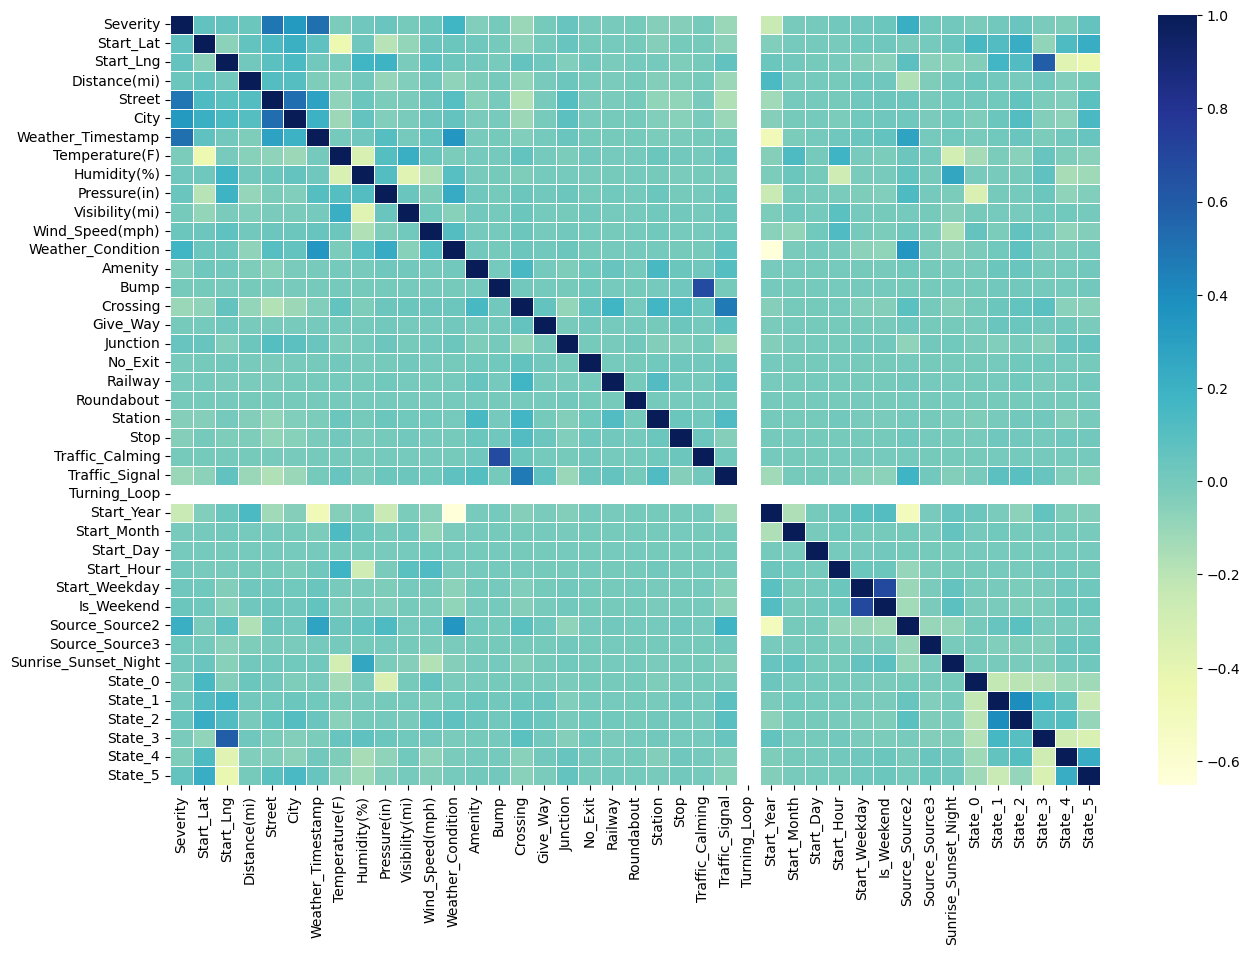

In [42]:
corr_mat = df.corr()
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr_mat, linewidths=0.5, cmap="YlGnBu")

#### Results from the EDA Analysis

1. Temperature and Accident Severity
	- Most of the accidents occur at temperatures between 50 and 80 degrees Fahrenheit. However, the number of accidents decreases as the temperature goes above 80 degrees or below 50 degrees.

2. City-wise Accident Distribution
	- The majority of cities have very few accidents, while only a small number of cities experience a significantly higher number of accidents.
	- Miami stands out as the city with the highest number of accidents.

3. Time of Day Impact
	- The majority of accidents occur during two critical time periods: the morning rush hour (6 AM to 9 AM) and the afternoon/evening rush hour (2 PM to 6 PM).

4. Time Distribution on Weekends vs. Weekdays
	- On weekends, accidents are more likely to happen between 10 AM and 3 PM.
	- On weekdays, accidents are concentrated during 6 AM to 9 AM and 3 PM to 5 PM.

5. Seasonal Trends
	- Accidents are more likely to occur during the winter and rainy seasons, indicating that weather conditions significantly impact accident rates.

## Modelling

### Splitting the data

In [43]:
# split data for modeling
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Severity"])
y = df["Severity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

After splitting the data into train and test sets we train it find the patterns and test it

We will try Logistic Regression.

We can also use other models like Random Forest, Decision Tree, KNN, SVM, XGBoost, etc. But due to the large size of the dataset, we will use Logistic Regression for now.

In [44]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logisticregression = LogisticRegression()
logisticregression.fit(X_train, y_train)
print("Logistic Regression Score: ", logisticregression.score(X_test, y_test))

c:\Users\ameyj\miniconda3\envs\dog-vision-project\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Score:  0.8584285794879041


In [45]:
y_pred = logisticregression.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00     16834
           2       0.87      0.97      0.92   1538498
           3       0.75      0.51      0.61    325593
           4       0.83      0.00      0.01     51174

    accuracy                           0.86   1932099
   macro avg       0.61      0.37      0.38   1932099
weighted avg       0.84      0.86      0.83   1932099



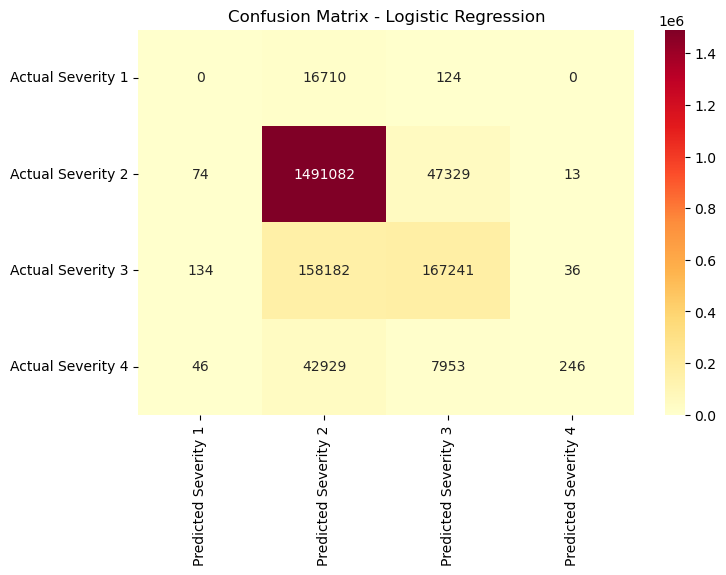

In [46]:
cm = confusion_matrix(y_test, y_pred)

index = [
    "Actual Severity 1",
    "Actual Severity 2",
    "Actual Severity 3",
    "Actual Severity 4",
]
columns = [
    "Predicted Severity 1",
    "Predicted Severity 2",
    "Predicted Severity 3",
    "Predicted Severity 4",
]
conf_matrix = pd.DataFrame(data=cm, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlOrRd")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

The model mostly predicts Severity 2 for all cases, no matter what the actual severity is. This causes it to struggle with predicting other severities like Severity 1, Severity 3, and Severity 4 correctly. While it does a good job predicting Severity 2 (shown by the high number in that category), it often mistakes other severity levels for Severity 2, as seen in the incorrect predictions.

To address this issue, we will use the undersampling technique to balance the data. This will help the model learn the patterns of all severity levels, not just Severity 2. We will then retrain the model and evaluate its performance.

In [48]:
# create a second version of data for undersampling
size = len(df[df["Severity"] == 1].index)
df_list = []  # Collect DataFrames in a list

for i in range(1, 5):
    S = df[df["Severity"] == i]
    df_list.append(S.sample(size, replace=True, random_state=42))

df_2 = pd.concat(df_list, ignore_index=True)

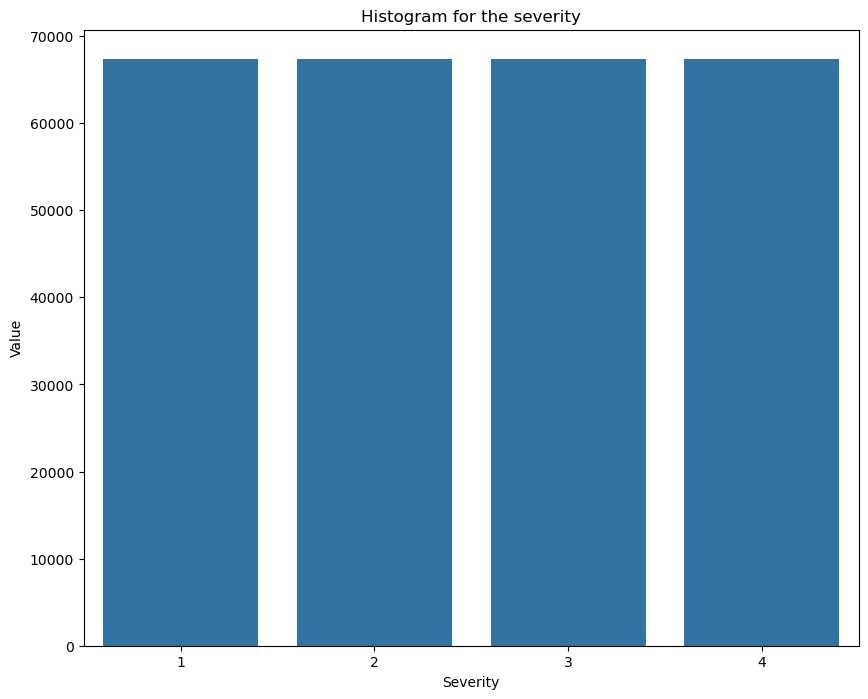

In [49]:
severity_counts = df_2["Severity"].value_counts()

plt.figure(figsize=(10, 8))
plt.title("Histogram for the severity")
sns.barplot(x=severity_counts.index, y=severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

### Training the model with balanced data

In [ ]:
X2 = df_2.drop(columns=["Severity"])
y2 = df_2["Severity"]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=42)

logisticregression2 = LogisticRegression()
logisticregression2.fit(X_train2, y_train2)
print(
    "Logistic Regression Score (Balanced Data): ",
    logisticregression.score(X_test2, y_test2),
)

Logistic Regression Score (Balanced Data):  0.5500103909984265


c:\Users\ameyj\miniconda3\envs\dog-vision-project\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
y_pred2 = logisticregression2.predict(X_test2)
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           1       0.54      0.64      0.59     16812
           2       0.39      0.33      0.36     16684
           3       0.60      0.57      0.59     16915
           4       0.64      0.65      0.65     16955

    accuracy                           0.55     67366
   macro avg       0.54      0.55      0.55     67366
weighted avg       0.54      0.55      0.55     67366



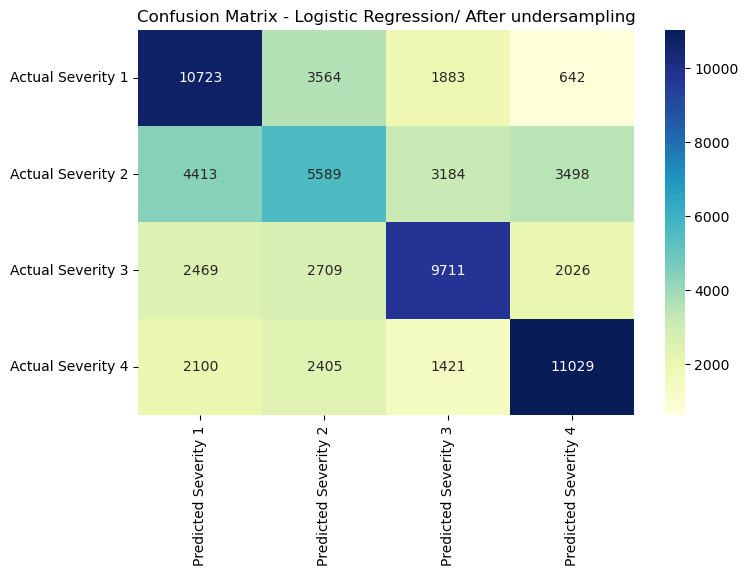

In [ ]:
cm2 = confusion_matrix(y_test2, y_pred2)

index = [
    "Actual Severity 1",
    "Actual Severity 2",
    "Actual Severity 3",
    "Actual Severity 4",
]
columns = [
    "Predicted Severity 1",
    "Predicted Severity 2",
    "Predicted Severity 3",
    "Predicted Severity 4",
]
conf_matrix = pd.DataFrame(data=cm2, columns=columns, index=index)
plt.figure(figsize=(8, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Confusion Matrix - Logistic Regression/ After undersampling")
plt.show()

Summary of Differences:

- Accuracy: The original model with imbalanced data has much higher accuracy (0.86) compared to the undersampled model (0.55).
- Precision and Recall: The original model has very high precision and recall for class 2, but poor performance for the other classes. The undersampled model has more balanced precision and recall across all classes, but still lower than the original model for class 2.
- F1-Score: The original model has a high F1-score for class 2 but very low F1-scores for the other classes. The undersampled model achieves more consistent F1-scores across classes, but they are generally lower than the original model for class 2.
- Macro Avg: The macro averages in the undersampled data are more balanced, reflecting the more even distribution of predictions across all classes, while the original model shows a significant imbalance, especially in recall.
- Weighted Avg: In the original data, the weighted averages are much higher, reflecting the dominance of class 2, while the undersampled model has lower weighted averages due to the more balanced but overall weaker performance across classes.

In summary, while the original model shows strong performance for class 2 but poor performance for the other classes, the undersampled model provides a more balanced performance across all classes but with generally lower overall accuracy and performance.

## Hyperparameter Tuning

Tuning Logistic Regression using RandomizedSearchCV

In [56]:
# Creating hyperparameter grid for logistic regression
grid = {"C": np.logspace(-4, 4, 20), "solver": ["liblinear"]}

In [58]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

### Hyperparameter Tuning for Undersampled Model

In [60]:
# Tune logistic regression
np.random.seed(42)

# Setup random hyperparameter search for LogisticRegression
rs_log_reg = RandomizedSearchCV(
    LogisticRegression(), param_distributions=grid, cv=5, n_iter=20, verbose=True
)

# Fit model for logistic regression
rs_log_reg.fit(X_train2, y_train2)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5, estimator=LogisticRegression(), n_iter=20,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'solver': ['liblinear']},
                   verbose=True)

In [61]:
rs_log_reg.best_params_

{'solver': 'liblinear', 'C': 1438.44988828766}

In [62]:
rs_log_reg.score(X_test2, y_test2)

0.7215954635869727

After tuning the hyperparameters, and comparing model accuracy. We can see that the model accuracy has improved from 0.55 to 0.72 after hyperparameter tuning. This is a significant improvement, and the model is now better at predicting accident severity levels.

Logistic regression model stands way more 'accurate', so we further tune more hyperparameters of the same using `GridSearchCV`. 
But using GridSearchCV is computationally expensive, so we will stop at RandomizedSearchCV for now.

In [ ]:
# Different parameters for logistic regression

# log_reg_grid = {'C':np.logspace(-4, 4, 30),
#                 'solver':['liblinear']}

# gs_log_reg = GridSearchCV(LogisticRegression(),log_reg_grid, cv=5, verbose=True)
# gs_log_reg.fit(X_train2, y_train2)

## Model Evaluation
2. Confusion Matrix
3. Classification Report
4. Precision
5. Recall
6. F1 Score

In [65]:
from sklearn.metrics import precision_score, f1_score, recall_score, RocCurveDisplay

In [63]:
y_pred3 = rs_log_reg.predict(X_test2)

In [64]:
y_pred3

array([4, 4, 4, ..., 4, 3, 4], dtype=int64)

In [67]:
confusion_matrix(y_test2, y_pred3)

array([[13509,  1354,   787,  1162],
       [ 3667,  7278,  3169,  2570],
       [  468,   432, 14211,  1804],
       [  376,  1777,  1189, 13613]], dtype=int64)

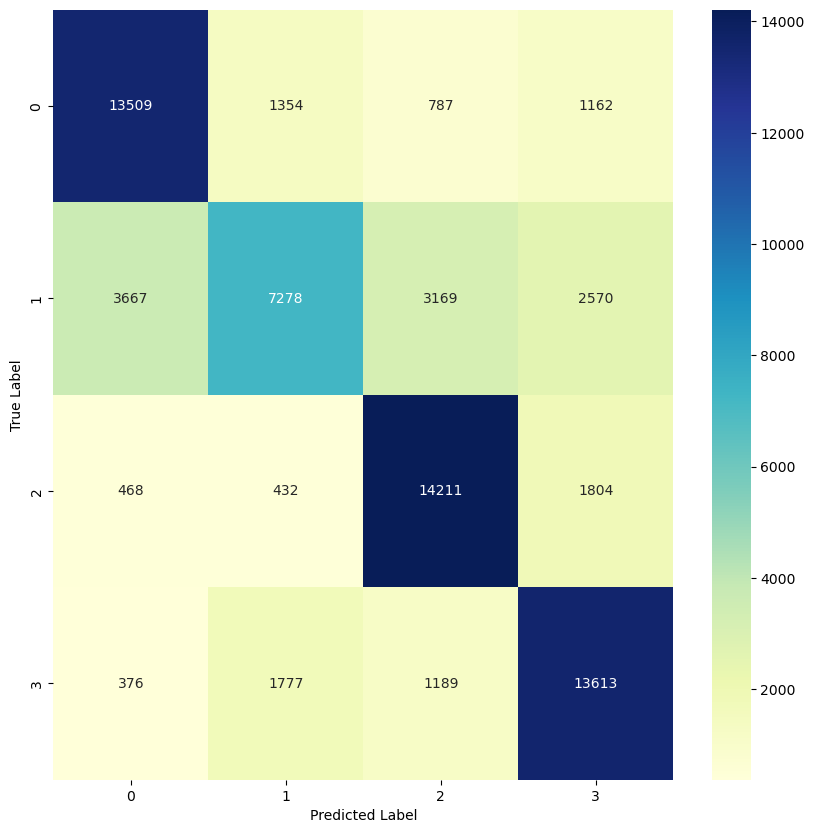

In [68]:
def plot_confusion_matrix(y_test, y_pred):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax = sns.heatmap(
        confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="YlGnBu"
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")


plot_confusion_matrix(y_test2, y_pred3)

In [69]:
print(classification_report(y_test2, y_pred3))

              precision    recall  f1-score   support

           1       0.75      0.80      0.78     16812
           2       0.67      0.44      0.53     16684
           3       0.73      0.84      0.78     16915
           4       0.71      0.80      0.75     16955

    accuracy                           0.72     67366
   macro avg       0.72      0.72      0.71     67366
weighted avg       0.72      0.72      0.71     67366



## Conclusion

The analysis and modeling of the US accidents dataset demonstrated the importance of data cleaning, feature engineering, and addressing class imbalance in predictive modeling. While the Logistic Regression model showed improvement after hyperparameter tuning, further exploration of additional models and techniques may yield even better results. Overall, this study highlights the potential of machine learning in predicting accident severity and the need for continuous refinement of models to enhance accuracy and reliability.